In [290]:
import baostock as bs
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [291]:
lg = bs.login()
print(f'login respond code: {lg.error_code}')
print(f'login respond msg: {lg.error_msg}')
params = ','.join(['date', 'open', 'high', 'low', 'close', 'preclose','volume','amount','turn', 'tradestatus', 'pctChg'])

login success!
login respond code: 0
login respond msg: success


In [292]:
def query_history_k_data_plus_with_df(**kwargs) -> pd.DataFrame:
    rs = bs.query_history_k_data_plus(**kwargs)
    data_list = []
    if rs.error_code!='0':
        raise Exception(f'error in fetch message: {rs.error_msg}')
    while rs.error_code == '0' and rs.next():
        data_list.append(rs.get_row_data())
    return pd.DataFrame(data_list, columns=rs.fields)

In [293]:
def fill_suspension(raw_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    start = datetime.strptime(start_date,'%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_counter = dict()
    columns = raw_df.columns.tolist()
    date_index = columns.index('date')
    close_index = columns.index('close')
    for r in raw_df.values:
        date_counter[r[date_index]] = list(r)
    first_record = raw_df.iloc[0]
    first_date = datetime.strptime(first_record['date'],'%Y-%m-%d')
    current = start
    last_close = first_record['close']
    while current < first_date:
        current_str = current.strftime('%Y-%m-%d')
        date_counter[current_str] = [current_str,last_close, last_close, last_close,last_close,last_close,0,0.0,0.0,0,0.0]
        current = current + timedelta(days=1)
    while current <= end:
        current_str = current.strftime('%Y-%m-%d')
        if date_counter.get(current_str) is None:
            last_day_str = (current + timedelta(days=-1)).strftime('%Y-%m-%d')
            last = date_counter.get(last_day_str) 
            last_close = last[close_index]
            date_counter[current_str] = [current_str,last_close, last_close, last_close,last_close,last_close,0,0.0,0.0,0,0.0] 
        current = current + timedelta(days=1)
    new_data = sorted(date_counter.values(),key=lambda x: x[date_index])
    return pd.DataFrame(new_data,columns=columns)

In [294]:
import os
import csv

def load_history_k_data_plus_with_df(**kwargs) -> pd.DataFrame:
    code = kwargs.get('code')
    frequency = kwargs.get('frequency')
    adjust = kwargs.get('adjustflag')
    path = os.path.join('.','resources',f'{code}-{frequency}-{adjust}.csv')
    if not os.path.exists(path):
        rs = query_history_k_data_plus_with_df(**kwargs)
        rs = fill_suspension(rs, kwargs.get('start_date'), kwargs.get('end_date'))
        rs.to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)
    rs = pd.read_csv(path, quoting=csv.QUOTE_NONNUMERIC)
    return rs

In [295]:

start_date = '2006-01-01'
end_date = '2019-10-20'

In [296]:
# back adjust
#rs_ba = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '1')
# front adjust
#rs_fa = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '2')
# no adjust
rs_no  = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '3')

In [297]:
rs_no.head()

,date,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg
0,2006-01-04,1163.878,1181.004,1161.906,1180.963,1161.057,2.325854e+09,1.197043e+10,0.015049,1.0,1.714473
1,2006-01-05,1183.305,1197.837,1180.451,1197.269,1180.963,2.948448e+09,1.476720e+10,0.019075,1.0,1.380740
2,2006-01-06,1198.811,1215.536,1191.614,1209.422,1197.269,3.434286e+09,1.713047e+10,0.022207,1.0,1.015056
3,2006-01-09,1210.320,1217.314,1205.248,1215.668,1209.422,2.870666e+09,1.420640e+10,0.018558,1.0,0.516443
4,2006-01-10,1215.848,1220.756,1203.651,1220.618,1215.668,2.679455e+09,1.349637e+10,0.017307,1.0,0.407190


In [298]:
rs_all = rs_no

In [299]:
window_sizes = [3,7,14,30,60,90,120,180]
dataset = rs_all.set_index('date')
dataset['predict'] = dataset['close'].shift(-1)
dataset['trend'] = (dataset['predict']-dataset['close']).apply(lambda x: x>=0)
dataset['range'] = dataset['high'] - dataset['low']
dataset['chg'] = dataset['close'] - dataset['open']
for window_size in window_sizes:
    window_name = f"window_{window_size}"
    dataset[f'{window_name}_high'] = dataset['high'].rolling(window_size).max()
    dataset[f'{window_name}_low'] = dataset['low'].rolling(window_size).max()
    dataset[f'{window_name}_range'] = dataset[f'{window_name}_high'] - dataset[f'{window_name}_low']
    dataset[f'{window_name}_open'] = dataset['open'].shift(window_size-1)
    dataset[f'{window_name}_close'] = dataset['close']
    dataset[f'{window_name}_chg'] = dataset[f'{window_name}_close'] - dataset[f'{window_name}_open']
    dataset[f'{window_name}_volume'] = dataset['volume'].rolling(window_size).sum()
    dataset[f'{window_name}_amount'] = dataset['amount'].rolling(window_size).sum()
    dataset[f'{window_name}_turn'] = dataset['turn'].rolling(window_size).sum()
    dataset[f'{window_name}_pctChg'] = dataset[f'{window_name}_chg']/dataset['preclose'].shift(window_size-1)
dataset = dataset.dropna(axis=0)
dataset.head()

,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg,...,window_180_high,window_180_low,window_180_range,window_180_open,window_180_close,window_180_chg,window_180_volume,window_180_amount,window_180_turn,window_180_pctChg
date,,,,,,,,,,,,,,,,,,,,,
2006-09-28,1725.515,1740.787,1722.219,1736.963,1725.039,3.397986e+09,1.991653e+10,0.016856,1.0,0.691235,...,1757.472,1737.999,19.473,1163.878,1736.963,573.085,6.619297e+11,3.612090e+12,3.761255,0.493589
2006-09-29,1740.059,1755.691,1740.059,1752.424,1736.963,4.123628e+09,2.346227e+10,0.020442,1.0,0.890113,...,1757.472,1740.059,17.413,1183.305,1752.424,569.119,6.637275e+11,3.623582e+12,3.766648,0.481911
2006-10-09,1768.144,1786.110,1763.111,1785.385,1752.424,5.293514e+09,2.908245e+10,0.026124,1.0,1.880884,...,1786.110,1763.111,22.999,1198.811,1785.385,586.574,6.660726e+11,3.637897e+12,3.773697,0.489927
2006-10-10,1784.220,1793.141,1771.856,1784.862,1785.385,5.513649e+09,3.145919e+10,0.027102,1.0,-0.029291,...,1793.141,1771.856,21.285,1210.320,1784.862,574.542,6.681519e+11,3.652226e+12,3.778592,0.475055
2006-10-11,1784.518,1792.761,1771.016,1790.104,1784.862,4.928388e+09,2.631018e+10,0.024225,1.0,0.293689,...,1793.141,1771.856,21.285,1215.848,1790.104,574.256,6.702097e+11,3.664330e+12,3.784259,0.472379


In [300]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

In [301]:
label_columns = ['predict', 'trend']
trend_column = 'trend'
predict_column = 'predict'
x_columns = list(set(dataset.columns.to_list())-set(label_columns))
x_train, x_test, trend_train, trend_test = train_test_split(dataset[x_columns],dataset[trend_column], test_size=0.9, random_state=0)
_, _, pred_train, pred_test = train_test_split(dataset[x_columns],dataset[predict_column], test_size=0.9, random_state=0)

In [302]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [303]:
x_train

array([[ 0.26218118, -0.42249922,  0.        , ..., -0.01527426,
        -0.66491527,  0.22804227],
       [-0.09934654, -0.75242523,  0.        , ...,  0.80917553,
        -0.85989725,  1.24216505],
       [ 0.0670235 , -0.34206445,  0.        , ..., -0.52387381,
        -0.33719401, -0.54876553],
       ...,
       [-1.28689263, -0.50853497,  0.        , ..., -0.13695501,
        -0.43404744, -1.06724387],
       [ 0.25533024, -0.00436989,  0.        , ..., -0.21953596,
        -0.04085235, -0.85594681],
       [ 0.44988223, -0.22096855,  0.        , ..., -0.97279631,
        -0.29213888, -0.99928797]])

In [304]:
import lightgbm as gbm
train_data = gbm.Dataset(x_train, label=trend_train)
validation_data = gbm.Dataset(x_test, label=trend_test)
params={
    'boosting_type': 'gbdt',
    'learning_rate': 0.005,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':5,
    'inbalance':'true',
    'objective': 'binary'
}
clf = gbm.train(params, train_data, valid_sets=[validation_data])
trend_pred = clf.predict(x_test)>=0.5
print(classification_report(trend_test, trend_pred))

[1]	valid_0's binary_logloss: 0.690659
[2]	valid_0's binary_logloss: 0.690568
[3]	valid_0's binary_logloss: 0.690481
[4]	valid_0's binary_logloss: 0.69044
[5]	valid_0's binary_logloss: 0.690361
[6]	valid_0's binary_logloss: 0.690327
[7]	valid_0's binary_logloss: 0.690255
[8]	valid_0's binary_logloss: 0.690227
[9]	valid_0's binary_logloss: 0.690161
[10]	valid_0's binary_logloss: 0.69014
[11]	valid_0's binary_logloss: 0.690081
[12]	valid_0's binary_logloss: 0.690066
[13]	valid_0's binary_logloss: 0.690014
[14]	valid_0's binary_logloss: 0.690004
[15]	valid_0's binary_logloss: 0.689959
[16]	valid_0's binary_logloss: 0.689955
[17]	valid_0's binary_logloss: 0.689916
[18]	valid_0's binary_logloss: 0.689918
[19]	valid_0's binary_logloss: 0.689884
[20]	valid_0's binary_logloss: 0.689892
[21]	valid_0's binary_logloss: 0.689865
[22]	valid_0's binary_logloss: 0.689841
[23]	valid_0's binary_logloss: 0.689856
[24]	valid_0's binary_logloss: 0.689838
[25]	valid_0's binary_logloss: 0.689859
[26]	valid_

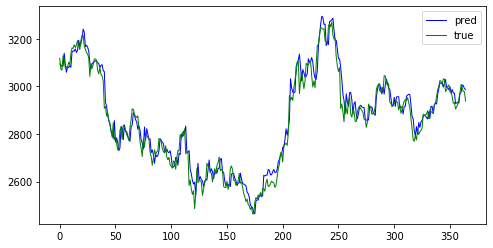

In [305]:
from matplotlib import pyplot as plt
points = 365
train_reg_data = gbm.Dataset(x_train, label=pred_train)
validation_reg_data = gbm.Dataset(x_test, label=pred_test)
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
}
clf = gbm.train(params,train_reg_data, valid_sets=[validation_reg_data])
pred_pred = clf.predict(x_test)
plt.figure(figsize=(8,4))
preds = clf.predict(scaler.transform(dataset[x_columns]))
trues = dataset[predict_column].tolist()
plt.plot(range(points),preds[-points:],'b-',label='pred',linewidth=1)
plt.plot(range(points),trues[-points:],'g-',label='true', linewidth=1)
plt.legend()

In [306]:
from sklearn.metrics import mean_squared_error
print(f"mean squared error: {mean_squared_error(preds, trues)}")

mean squared error: 12026.378082140625
